# A half-baked tutorial on ensemble methods
#### <center>by Ivan Nazarov<center/>

This tutorial covers both introductiory level theory underpinning
each ensemble method, as well as the tools available in Scikit-Learn
and XGBoost. We also cover the topic of Stacking.

## Materials

* **T. Hastie, R. Tibshirani, and J. Friedman.** `The Elements of Statistical Learning: Data  Mining, Inference, and  Prediction.` Springer Series in Statistics. Springer New York, 2013.
    1. Bagging: ch. 8.7;
    2. Random Forests: ch. 15;
    3. Boosting: ch. 10;
    4. Stacking: ch 8.8;
    5. Ensemble methods: ch. 16;


* **A. J. Izenman.** `Modern Multivariate Statistical Techniques: Regression, Classiffcation, and Manifold Learning.` Springer Texts in Statistics. Springer NewYork, 2009.
    1. Committee methods: ch. 14, pp. 506-510, 530-532;

Import the necessary modules and fix the RNG.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state

Toy data from **HTF, p. 339**

In [2]:
def htf_p339(n_samples=2000, p=10, random_state=None):
    random_state=check_random_state(random_state)
    ## Inputs
    X = random_state.normal(size=(n_samples, max(10, p)))
    ## Response: \chi^2_10 0.5-prob outliers
    y = (np.sum(X[:, :10]**2, axis=1) > 9.34).astype(int).reshape(-1)
    return X, y

Fix the RNG

In [3]:
random_state = np.random.RandomState(0xC01DC0DE)

Generate four samples

In [4]:
X_train, y_train = htf_p339(2000, 10, random_state)
X_test, y_test = htf_p339(10000, 10, random_state)

X_valid_1, y_valid_1 = htf_p339(2000, 10, random_state)
X_valid_2, y_valid_2 = htf_p339(2000, 10, random_state)

<hr/>

# Ensemble methods

In general any ensemble methods can be broken down into the following two
stages, possibly overlapping:
1. Populate a dictionary of base learners;
2. Combine them to get a composite predictor.

Many ML estimators can be considerd ensemble methods:
1. Regression is a linear ensemble of basis functions: predictors $x\in \mathbb{R}^{p\times 1}$;
2. Any model with additive structure, like regression/classificatio trees;
3. Feedforward Neural network is a bunch of layers of nonlinear predictors stacked one atop
the other, in a specific DAG-like manner;

## Trees

A regression tree is a piecewise constant function $T:\mathcal{X} \mapsto \mathbb{R}$
having the following expression

$$ T(x) = \sum_{j=1}^J w_j 1_{R_j}(x) \,, $$
where $(R_j)_{j=1}^J$, $J\geq 1$, is a tree-partition of the input space,
and $(w_j)_{j=1}^J$ are estimated values at terminal nodes.

In a multiclass problem, a classification tree is a composition of a **majority
voting** decision function

$$ \mathtt{MAJ}(y) = \mathop{\text{argmax}}_{k=1\,\ldots, K} y_k \,, $$
with a scoring funciton $T:\mathcal{X} \mapsto \mathbb{R}^K$ of similar structure
as in the regression case

$$ T(x) = \sum_{j=1}^J w_j 1_{R_j}(x) \,, $$
where $(w_j)_{j=1}^J\in\mathbb{R}^K$ are vectors of class likelihoods (probabilities)
at the terminal nodes.

The tree-partition $(R_j)_{j=1}^J$ and node values $(w_j)_{j=1}^J$ result from running
a variant of the **standard greedy top-down tree-induction algorithm** (CART, C.45, et c.).

In [5]:
from sklearn.tree import DecisionTreeClassifier

clf1_ = DecisionTreeClassifier(max_depth=1,
                               random_state=random_state).fit(X_train, y_train)
clf2_ = DecisionTreeClassifier(max_depth=3,
                               random_state=random_state).fit(X_train, y_train)
clf3_ = DecisionTreeClassifier(max_depth=7,
                               random_state=random_state).fit(X_train, y_train)
clf4_ = DecisionTreeClassifier(max_depth=None,
                               random_state=random_state).fit(X_train, y_train)

print "Decision tree (1 levels) error:", 1 - clf1_.score(X_test, y_test)
print "Decision tree (3 levels) error:", 1 - clf2_.score(X_test, y_test)
print "Decision tree (7 levels) error:", 1 - clf3_.score(X_test, y_test)
print "Decision tree (max levels) error:", 1 - clf4_.score(X_test, y_test)

Decision tree (1 levels) error: 0.4648
Decision tree (3 levels) error: 0.3932
Decision tree (7 levels) error: 0.3354
Decision tree (max levels) error: 0.2765


## Bagging

Bagging is meta algortihm that aims at constructing an esimator by averaging 
many noisyб but approximately unbiased models. The general idea is that averaging
a set of unbiased estimates, yields an estimate with much reduced variance
(provided the base estimates are uncorrelated).

Bagging works poorly on models, that linearly depend on the data (like linear
regression), and best performs on nonlinear base estimators (like trees). In
other terms bagging succeeds in building a better combined estimator, if the
base estimator is unstable. Indeed, if the learning procedure is stable, and
random perturbation of the train dataset do not affect it by much, the bagging
estimator will not differ much from a single predictor, and may even weak its
performance somewhat.

### Bootstrapping

Consider a train sample $Z = (X, y) = (x_i, y_i)_{i=1}^n \in \mathcal{X}\times \mathcal{Y}$,
samplesed form a distribution $P$.

A bootstrap sample $Z^* = (z^*_i)_{i=1}^n$ is a subsample of $Z = (z_j)_{j=1}^n$ with
each element drawn with **replacement** from $Z$. More technically, a bootstrap sample
of size $l$ is a sample from the empirical distribution of the training data $Z$, denoted
by $\hat{P}$. So $Z^*\sim \hat{P}^l$ means that $(z^*_i)_{i=1}^l \sim \hat{P}$ iid, or,
similarly,
$$ z^*_i = \bigl\{ z_j \text{ w. prob. } \frac{1}{n}\,,\, j=1, \ldots, n\bigr.\,. $$

An interesting property of a bootstraped sample, is that on average $36.79\%$ of
the original sample are left out of each $Z^{*b}$. Indeed, the probability that a
given sample is present in $Z^*$ is
$$ 1 - \bigl(1 - \frac{1}{n}\bigr)^n = 1 - e^{-1} + o(n) \approx 63.21\%\,. $$

This means that the observations not selected for the $b$-th bootstrap sample $Z^{*b}$,
denoted by $Z\setminus Z^{*b}$, $b=1,\ldots,B$, can be used as an independent test set.
The **out-of-bag** sample, $Z\setminus Z^{*b}$, and for estimating the generalization
error, and for defining an **OOB**-predictor.

For a given collection of bootstrap samples $(Z^{*b})_{b=1}^B$ define the set of samples
the $i$-th observation **does not** belong to as $\Gamma_i = \{b=1,\ldots, n\,:\, z_i \notin Z^{*b} \}$,
$i=1,\ldots, n$. For a fixed observation $i$ the set $\Gamma_i$ is empty, meaning that
$z_i$ is **never** out-of-bag, occurs with probability $\bigl(1 - (1-n^{-1})^n\bigr)^B
\approx (1-e^{-1})^B$, which is negligible for $B \geq 65$.

### Regression

Let $\mathcal{A}$ is a learning algorithm, taking a learning sample, that learns
regression models $\hat{f}:\mathcal{X} \mapsto \mathbb{R}$, like Regression Tree,
$k$-NN, multi-layer neural netowrk et c. The bagged regression estimator is constructed
as follows:
1. Draw $B$ independent bootstrap samples $(Z^{*b})_{b=1}^B$;
2. On each bootstrap sample $Z^{*b}$ learn an estimator $\hat{f}^{*b} = \hat{f}^{*b}(\cdot; Z^{*b})
= \mathcal{A}(Z^{*b})(\cdot)$;
3. Construct the bagged estimator:
$$ \hat{f}^{\text{bag}}_B(x) = B^{-1} \sum_{b=1}^B \hat{f}^*(x) \,. $$

The bagged estimator $\hat{f}^{\text{bag}}_B$ is different from the original-sample
estimator $\hat{f}=\hat{f}(\cdot; Z)$ if the ML algorithm is nonlinear on the data,
or adaptive. Bagged estimator $\hat{f}^{\text{bag}}_B$ is a Monte-Carlo approximation
of the ideal Bagging estimator, given by the function

$$ \hat{f}^{\text{bag}}(x) = \mathop{\mathbb{E}}\nolimits_{Z^*} \hat{f}^*(x; Z^*) \,.$$

By the law of large numbers we have $\hat{f}^{\text{bag}}_B \to \hat{f}^{\text{bag}}$
with probability one (over the empirical distribution $\hat{P}$) as $B\to \infty$.

OOB samples can be used to construct the OOB-predictor -- an estimator, defined only
for the training samples:
$$\hat{f}^{\text{oob}}_b (x_i) = \frac{1}{|\Gamma_i|} \sum_{b\in \Gamma_i} \hat{f}^{*b}(x_i) \,, $$
and based on it the OOB mean squared error:
$$ \text{oob-MSE} = n^{-1} \sum_{i=1}^n \bigl(y_i - \hat{f}^{\text{oob}}_B(x_i)\bigr)^2 \,, $$
where observations with $\Gamma_i=\emptyset$ are omitted.

### Classification

In case of classification the baggin estimator is constructed similarly, but there
are important caveats. In this case the ML algorithm learns a class-score function
$\hat{f}:\mathcal{X} \mapsto \mathbb{R}^K$, and then the class label is predicted
by $\mathtt{MAJ}$ (majority voting) on $\hat{f}(x)$.

The majority vote over $K$ candidates with weights $(w_k)_{k=1}^K\in \mathbb{R}$ is defined as
$$ \mathtt{MAJ}(w) = \mathop{\text{argmax}}_{k=1\,\ldots, K} w_k \,. $$

One option is to define the bagged estimator as
$$ \hat{g}^{\text{bag}}_B(x)
    = \mathtt{MAJ}\Bigl( B^{-1}\sum_{b=1}^B e_{k^{*b}(x)} \Bigr)
    \,, $$
where $e_k$ is the $k$-th unit vector in $\{0,1\}^{K\times 1}$, and
$k^{*b}(x)=\mathtt{MAJ}\bigl(\hat{f}^{*b}(x)\bigr)$.
Basically, this ensemble classifies according to voting proportions of the population
of bootstrapped classifiers. However, when most calssifiers within the population
classify some class correctly, then its voting poportion will overestimate the
class probability.

A better option, especially for well-calibrated classfiers is to use their scores directly:
$$ \hat{g}^{\text{bag}}_B(x)
    = \mathtt{MAJ}\bigl( B^{-1}\sum_{b=1}^B \hat{f}^{*b}(x) \bigr)
    \,, $$

One can construct an OOB-classifier (or generally an OOB-predictor) using the following
idea:
$$ \hat{g}^{\text{oob}}_B(x_i)
    = \mathtt{MAJ}\Bigl(
        \frac{1}{|\Gamma_i|} \sum_{b\in \Gamma_i} e_{k^{*b}(x_i)}
        \Bigr)\,, $$
or
$$ \hat{g}^{\text{oob}}_B(x_i)
    = \mathtt{MAJ}\Bigl(
        \frac{1}{|\Gamma_i|} \sum_{b\in \Gamma_i} \hat{f}^{*b}(x_i)
        \Bigr)\,. $$
Obviously, this classifier is defined only for the observed samples data, and for only those
examples, for which $\Gamma_i\neq\emptyset$.

Bagging a good classifier (one with misclassification rate **less** than $0.5$) can
improve its accuracy, while bagging a poor one (with higher than $0.5$ error rate)
can seriously degrade predictive accuracy.

#### Usage 

In [6]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

Both Bagging Calssifier and Regressor have similar parameters:
- **n_estimators** -- the number of estimators in the ensemble;
- **base_estimator** -- the base estimator from which the bagged ensemble is
built;
- **max_samples** -- the fraction of samples to be used to train each
individual base estimator. Choosing `max_samples < 1.0` leads to a reduction
of variance and an increase in bias.
- **max_features** -- The number of features to draw from X to train each
base estimator;
- **bootstrap** -- determines whether samples are drawn with replacement;
- **bootstrap_features** -- determines whether features are drawn with replacement;
- **oob_score** -- determines whether to use out-of-bag samples to estimate
    the generalization error;

#### Example

In [7]:
clf1_ = BaggingClassifier(n_estimators=10,
                          base_estimator=DecisionTreeClassifier(max_depth=3),
                          random_state=random_state).fit(X_train, y_train)
clf2_ = BaggingClassifier(n_estimators=10,
                          base_estimator=DecisionTreeClassifier(max_depth=None),
                          random_state=random_state).fit(X_train, y_train)
clf3_ = BaggingClassifier(n_estimators=100,
                          base_estimator=DecisionTreeClassifier(max_depth=3),
                          random_state=random_state).fit(X_train, y_train)
clf4_ = BaggingClassifier(n_estimators=100,
                          base_estimator=DecisionTreeClassifier(max_depth=None),
                          random_state=random_state).fit(X_train, y_train)

print "Bagged (10) decision tree (3 levels) error:", 1 - clf1_.score(X_test, y_test)
print "Bagged (10) decision tree (max levels) error:", 1 - clf2_.score(X_test, y_test)
print "Bagged (100) decision tree (3 levels) error:", 1 - clf3_.score(X_test, y_test)
print "Bagged (100) decision tree (max levels) error:", 1 - clf4_.score(X_test, y_test)

Bagged (10) decision tree (3 levels) error: 0.3228
Bagged (10) decision tree (max levels) error: 0.2007
Bagged (100) decision tree (3 levels) error: 0.2895
Bagged (100) decision tree (max levels) error: 0.1704


<hr/>

### Random Forest

Essentially, a random forest is an bagging ensemble constructed from a large collection
of **decorrelated** regression/decision trees. The algorithm specifially modifies
the tree induction procedure to produce trees with as low correlation  as possible.
1. for $b=1,\ldots, B$ do:
    1. Draw a bootstrap sample $Z^{*b} = (z^{*b}_i)_{i=1}^P$, of size $P = \lfloor \eta n\rfloor$ from $Z$;
    2. Grow a tree $T^{*b}$ in a specialized manner: the greedy recursive algorithm
    is the same, but each time split candidates are chosen from **a random subset of
    features**, and the tree is grown until a minimum node size is reached;
2. Take the tree ensemble $(\hat{T}^{*b})_{b=1}^B$, and return the bagged estimator;

Trees benefit the most from bagging and random forest ensembles due to their high nonlinearity.

#### Usage

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

As with Bagging, Random Forest Classifier and Regressor accept similar parametrs:
- **criterion** -- the function to measure the quality of a split. Supported criteria
are:
    * _"gini"_ -- Gini impurity (classification only);
    * _"entropy"_ -- the information gain (classification only);
    * _"mse"_ -- mean squared error (regression only);
- **max_features** -- The number of features to consider when looking for the
best split: `sqrt`, `log2` and share in $(0,1]$ are accepted (choosing `max_features < n_features`
leads to a reduction of variance and an increase in bias);
- **max_depth** -- maximum depth of the individual regression tree estimators
(the maximum depth limits the number of nodes in the tree, the best value depends
on the interaction of the input variables);
- **min_samples_split** -- The minimum number of samples required to split an
internal node;
- **min_samples_leaf** -- The minimum number of samples required to be at a
leaf node;
- **min_weight_fraction_leaf** -- The minimum weighted fraction of the input
samples required to be at a leaf node;
- **max_leaf_nodes** -- Grow trees with ``max_leaf_nodes`` in best-first
fashion, determined by the relative reduction in impurity;
- **bootstrap** -- determines whether samples are drawn with replacement;
- **oob_score** -- determines whether to use out-of-bag samples to estimate
    the generalization error.

Note that in Scikit-learn the bootstrap sample size is the same as teh original
sample ($\eta=1$).

**RandomForestClassifier** also handles imbalanced classification problems via
the `class_weight` parameter:

- **class_weight** --  weights associated with classes given in the form of a
dictionary with elements `{class_label: weight}`, or a rebalancing mode:
    * _"balanced"_ -- mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data;
    * _"balanced__subsample"_ -- mode is the same as "balanced", except that
    weights are re-computed based on the bootstrap sample for every tree grown.
    These weights will be used to adjust the sample weight (passed
    through the fit method).

#### Example

In [9]:
clf1_ = RandomForestClassifier(n_estimators=10, max_depth=3,
                               random_state=random_state).fit(X_train, y_train)
clf2_ = RandomForestClassifier(n_estimators=100, max_depth=3,
                               random_state=random_state).fit(X_train, y_train)
clf3_ = RandomForestClassifier(n_estimators=10, max_depth=None,
                               random_state=random_state).fit(X_train, y_train)
clf4_ = RandomForestClassifier(n_estimators=100, max_depth=None,
                               random_state=random_state).fit(X_train, y_train)

print "Random Forest (10, 3 levels) error:", 1 - clf1_.score(X_test, y_test)
print "Random Forest (100, 3 levels) error:", 1 - clf2_.score(X_test, y_test)
print "Random Forest (10, max levels) error:", 1 - clf3_.score(X_test, y_test)
print "Random Forest (100, max levels) error:", 1 - clf4_.score(X_test, y_test)

Random Forest (10, 3 levels) error: 0.2799
Random Forest (100, 3 levels) error: 0.2544
Random Forest (10, max levels) error: 0.2
Random Forest (100, max levels) error: 0.1525


<hr/>

## Boosting

### Classification

The underlying idea of boosting is to combine a collection of weak predictors,
into one strong powerful committee model. Most commonly a dictionary of nonlinear
base predictors, like decision trees (regression/classification), is used weak
predictors in boosting.

Consider the following classification problem: learn a hypothesis (algorithm)
$h:\mathcal{X}\mapsto \{-1,1\}$ that is able to generalize well beyond the given
learning sample $Z = (X, y) = (x_i, y_i)_{i=1}^n \in \mathcal{X}\times \{-1, +1\}$.
The empirical risk is the sample average loss
$$ \hat{\mathcal{R}}_Z(h(\cdot))
    = n^{-1} \sum_{i=1}^n L(h(x_i), y_i)
    = \mathbb{E}_{(x,y)\sim Z} L(h(x), y) \,, $$
where $\mathbb{E}_Z$ denotes the expectation over the empirical measure induced
by $Z$.

Theoretically, it would be great to learn such a classifier $g:\mathcal{X}\mapsto\{-1,+1\}$,
that minimizes the theoretical risk

$$ \mathcal{R}(h(\cdot)) = \mathbb{E}_{(x, y)\sim D} 1_{y\neq h(x)} \,, $$

where $D$ is the true unknown distribution on $\mathcal{X} \times \{-1, +1\}$ of
the data. The ideal calssifier given by the Bayes classifier $g^*(x) = \mathbb{P}_D(y=1|X=x)$.

However, this functional is unavailable in real life, and thus we have to get
by minimizing the empirical risk, which is known to be an approximation of the
theoretical risk due to the Law of Large Numbers. We do this, hoping that
$$ \hat{h} \in
    \mathop{\text{argmin}}_{g\in \mathcal{F}}
        \hat{\mathcal{R}}_Z(g(\cdot)) \,, $$
also more-or-less minimizes the theoretical risk.

Furthermore for a general class of hypotheses $h:\mathcal{X}\mapsto \{-1,+1\}$, the
empirical risk minimization problem cannot be solved efficiently due to non-convexity
of the objective function.

### FSAM
**F**orward **S**tagewise **A**dditive **M**odelling is a general greedy approach
to modelling **additive enesembles** (generalized additive models). The basic idea
of this approach is to construct a suboptimal model incrementally in a greedy fashion.
The goal is to minimize $\sum_{i=1}^n L(y_i, f(x_i)) + \Omega(f)$ over some class
$f\in \mathcal{F}$, where $\Omega(\cdot)$ is an additive complexity regularizer.

**Algorithm**:
1. set $F_0 = 0$;
2. for $k = 1,\ldots, K$ do:
    1. using some efficient method find at least a good approximation to the following:
    $$ f_k 
        \leftarrow \mathop{\mathtt{argmin}}\limits_{f\in \mathcal{F}}
            \sum_{i=1}^n L\bigl( y_i, F_{k-1}(x_i) + f(x_i)\bigr)
            + \Omega(F_{k-1}) + \Omega(f)
        \,; $$
    2. set $ F_k = F_{k-1} + f_k$;
3. Return $F_K$.

### AdaBoost

The **AdaBoost** algorithm is based on the **F**orward-**S**tagewise **A**dditive **M**odelling
approach, which implements a greedy strategy of constructing an additive model, such as
an ensemble (or even a tree), from a rich dictionary of basis functions. In classification,
it is a particular example of a convex relaxation of the empirical risk minimization problem:
**AdaBoost** dominates the $0-1$ loss $(y, p)\mapsto 1_{y p < 0}$ with exp-loss $(y,p)\mapsto e^{-yp}$
and minimizes a convex upper bound of the classification error.

##### AdaBoost.M1
1. initialize $\omega_{1i} \leftarrow \frac{1}{n}$, $i=1\ldots, n$;
2. for $m=1,\ldots, M$ do:
    1. fit a classifier $\hat{g}_m$ to $(X, y)$ with sample weights $(\omega_{mi})_{i=1}^n$;
    2. get the miscassification error $\epsilon_m = W_m^{-1} \sum_{i\,:\,y_i\neq \hat{g}_m(x_i)} \omega_{mi}$,
    for $W_m = \sum_{i=1}^n \omega_{mi}$;
    3. compute the log-odds ratio $\alpha_m = \log \frac{1-\epsilon_m}{\epsilon_m}$;
    4. update the weights:
    $\omega_{m+1,t} \leftarrow \omega_{mi} \text{exp}\bigl( \alpha_m 1_{\{i\,:\,y_i\neq \hat{g}_m(x_i)\}} \bigr)$;
3. Output the ensemble $\hat{g} = \mathop{\text{sign}}\bigl\{\sum_{m=1}^m \alpha_m \hat{g}_m\bigr\}$;

The **AdaBoost.M1** algorithm employs an adversarial teaching approach to strengthen
the ensemble. As is visible from the algorithm, the teacher tries to maximize the
classification error of the learner by amplifying the weights of the difficult to
classify examples.

The size of the ensemble $M$ serves as a regularization parameter, since
the greater the $M$, the more boosting overfits. An `optimal` $M$ can be
chosen by cross-validation (preferably on a single common validation set).

A recent development, called **DeepBoost** [Mohri et al.; 2014](http://research.google.com/pubs/pub42856.html),
proposes a new ensemble learning algorithm, that is similar in spirit to
**AdaBoost**. Its key feature is that the algorithm incorporates a complexity
penalty for convex combinations of models into the convex relaxation of
the loss criterion. This enables selection of better hypotheses that minimize
the upper bound on the theoretical risk.

#### Usage 

In [10]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

Common parameters:
- **n_estimators** -- the maximum number of estimators at which boosting is
terminated (in **case of perfect fit**, the learning procedure is stopped early);
- **base_estimator** -- the base estimator, which supports **sample weighting**,
from which the boosted ensemble is built;
- **learning_rate** -- learning rate shrinks the contribution of each classifier
by `learning_rate`.

AdaBoostClassifier only:
- **algorithm** -- the AdaBoost version to use:
    * _"SAMME.R"_ -- the SAMME.R real boosting algorithm;
    * _"SAMME"_ -- the SAMME (**M1**) discrete boosting algorithm;
    The `SAMME.R` algorithm typically converges faster than `SAMME`,
    achieving a lower test error with fewer boosting iterations.

AdaBoostRegressor only:
- **loss** -- the loss function to use when updating the weights after each
    boosting iteration:
    * _"linear"_ -- absolute loss $L(y, p) = |y-p|$;
    * _"square"_ -- squared loss $L(y, p) = |y-p|^2$;
    * _"exponential"_ -- Exponential loss $L(y, p) = 1-e^{-|y-p|}$.

#### Examples

In [11]:
clf1_ = AdaBoostClassifier(n_estimators=10, 
                           base_estimator=DecisionTreeClassifier(max_depth=1),
                           random_state=random_state).fit(X_train, y_train)
clf2_ = AdaBoostClassifier(n_estimators=100, 
                           base_estimator=DecisionTreeClassifier(max_depth=1),
                           random_state=random_state).fit(X_train, y_train)
clf3_ = AdaBoostClassifier(n_estimators=10, 
                           base_estimator=DecisionTreeClassifier(max_depth=3),
                           random_state=random_state).fit(X_train, y_train)
clf4_ = AdaBoostClassifier(n_estimators=100,
                           base_estimator=DecisionTreeClassifier(max_depth=3),
                           random_state=random_state).fit(X_train, y_train)

print "AdaBoost.M1 (10, stumps) error:", 1 - clf1_.score(X_test, y_test)
print "AdaBoost.M1 (100, stumps) error:", 1 - clf2_.score(X_test, y_test)
print "AdaBoost.M1 (10, 3 levels) error:", 1 - clf3_.score(X_test, y_test)
print "AdaBoost.M1 (100, 3 levels) error:", 1 - clf4_.score(X_test, y_test)

AdaBoost.M1 (10, stumps) error: 0.3116
AdaBoost.M1 (100, stumps) error: 0.0804
AdaBoost.M1 (10, 3 levels) error: 0.1791
AdaBoost.M1 (100, 3 levels) error: 0.1491


<hr/>

### Gradient boosting

In certain circumstances in order to minimize a convex twice-differentiable
function $f:\mathbb{R}^p \mapsto \mathbb{R}$ one uses Newton-Raphson iterative
procedure, which repeats until convergence this update step:
$$ x_{m+1} \leftarrow x_m - \bigl(\nabla^2 f(x_m)\bigr)^{-1} \nabla f(x_m) \,, $$
where $\nabla^2 f(x_m)$ is the hessian of $f$ at $x_m$ and $\nabla f(x_m)$ is its
gradient.

In a more general setting, if the function is not twice differentiable, or if
the hessian is expensive to compute, then one resorts to a **gradient descent**
procedure, which moves in the direction os teh steepest descent and updates
according to
$$ x_{m+1} \leftarrow x_m - \eta \nabla f(x_m) \,,$$
for some step $\eta > 0$.

Gradient Boosting is, to a certain extent, a gradient descent procedure aimed at
minimizing an expected loss functional $\mathcal{L}: \mathcal{F}\mapsto \mathbb{R}$
on some function space $\mathcal{F} \subset \mathbb{R}^{\mathcal{X}}$. In particular,
it the underlying distribution of the data were known, Gradient Boosting would
attempt to find a minimizer $x\mapsto \hat{f}(x)$ such that for all $x\in \mathcal{X}$
$$ \hat{f}(x)
    = \mathop{\text{argmin}}_{f\in\mathcal{F}}
        \mathbb{E}_{y \sim P|x} L(y, f(x)) \,. $$

At each itration it would update the current estimate of the minimizer $\hat{f}_m$
in the direction of the steepest-descent towards $\hat{f}$:
$$ \hat{f}_{m+1} \leftarrow \hat{f}_m - \rho \hat{g}_m \,, $$
where $\hat{g}_m \in \mathcal{F}$ is given by
$$ \hat{g}_m(x) = \biggl. \frac{\partial}{\partial f(x)}
    \Bigl( \mathbb{E}_{y \sim P|x} L\bigl(y, f(x)\bigr) \Bigr)
    \biggr\rvert_{f=\hat{f}_m}
     = \biggl.
    \mathbb{E}_{y \sim P|x} \frac{\partial}{\partial f(x)}L\bigl(y, f(x)\bigr)
    \biggr\rvert_{f=\hat{f}_m} \,, $$
(under some regularity conditions it is possible to interchange the expectation
and differentiation operation). In turn $\rho$ is determined by
$$ \rho = \mathop{\text{argmin}}_\rho \mathbb{E}_{(x,y) \sim P} L(y, \hat{f}_m(x) - \rho \hat{g}_m(x)) \,. $$


Since in practice the expectaions are not known, one approximates them with their
empirical counterparts, which makes the gradient undefined outside the observed
sample points. That is why one needs a class of basis functions, which can 
generalize the gradient from a point to its neighbourhood.

**Gradient Boosting procedure**
1. Initialize the ensemble with $\hat{f}_0 \leftarrow \mathop{\text{argmin}}_\gamma \sum_{i=1}^n L(y_i, \gamma)$;
2. for $m=1,\ldots, M$ do:
    1. **Gradient approximation**: Compute the current sample descent direction (negative
    gradient) using the current ensmeble:
    $$ r_{mi} = \biggl.
            - \frac{\partial}{\partial f(x_i)} L\bigl(y_i, f(x_i)\bigr)
        \biggr\rvert_{f=f_{m-1}} \,, $$
    this can be thought of as a finte-dimensional approximation of a functional
    gradient $\delta \mathcal{L}$ of the loss functional $\mathcal{L}$;
    2. Fit an MSE minimizing parametric basis function $h(x;\theta)$ to the approximation
    of the gradient $(r_{mi})_{i=1}^n$:
    $$ (\theta_m, \beta_m)
        \leftarrow \mathop{\text{argmin}}_{\theta, \beta}
            \sum_{i=1}^n \bigl(r_{mi} - \beta h(x_i;\theta) \bigr)^2\,; $$
    basically we hope that $h(\cdot;\theta)$ approximates the functional gradient well
    enought and extrapolates beyond the point estimates to their immediate neighbourhoods;
    3. **Line search**: determine the optmial `step` in the direction of the `functional`
    `gradient` that minimizes the loss functional:
    $$ \gamma_m \leftarrow \mathop{\text{argmin}}_\gamma
       \sum_{i=1}^n L\bigl(y_i, f_{m-1}(x_i) + \gamma h(x_i;\theta_m)\bigr)\,;$$
    4. Update the ensemble $f_m = f_{m-1} + \eta \, \gamma_m h(\cdot;\theta_m)$;
3. Return $\hat{f}(x) = f_M(x)$;

Here $\eta$>0 is the learning rate.

### Gradient Boosted Regression Trees

Gradient Boost algorithm uses basis functions $h(\cdot; \theta)$ from some class
to approximate the gradient. For example, one can use regression splines, or more
generally fit a kernel ridge regression for gradient interpolation, or use regression
trees. Regression trees do not assume a predetermined parametric form, and instead
are constructed according to information derived from the data.

#### Algorithm

With a given tree-partition structure $(R_j)_{j=1}^J$, it is really straightforward
to find optimal estimates $(w_j)_{j=1}^J\in \mathbb{R}$.

Now finding an optimal partition $(R_j)_{j=1}^J$ is entirely different matter: exhaustive
search is out of question, so the algorithm to go is the greedy top-down recursive
partitioning procedure.

Boosted trees is an ensemble $\hat{f}(x) = \sum_{m=1}^M \hat{f}_m(x)$, with weights
incorporated in each base estimator.

**GBRT**
1. Initialize the ensemble with $\hat{f}_0 \leftarrow \mathop{\text{argmin}}_\gamma \sum_{i=1}^n L(y_i, \gamma)$;
2. for $m=1,\ldots, M$ do:
    1. Compute the current sample descent direction (negative gradient) using the current ensmeble:
    $$ r_{mi} = \biggl.
            - \frac{\partial}{\partial f(x_i)} L\bigl(y_i, f(x_i)\bigr)
        \biggr\rvert_{f=f_{m-1}} \,, $$
    this is a finte-dimensional version of the first **variation** $\delta J$
    of a functional $J:\mathbb{R}^{\mathcal{X}}\mapsto \mathbb{R}$ on some
    function space;
    2. Fit an MSE minimizing regression tree $\hat{T}_m = \sum_{j=1}^J \beta_j 1_{R_{mj}}(x)$
    to the current gradient $(r_{mi})_{i=1}^n$ and keep its partition structure;
    basically, we want to `generalize` the point estimates of the variation to 
    some neighbourhood of each sample point (here the heighbourhoods are the tree
    partitions);
    3. **Line search**: determine the optmial node-weights
    $$w_{mj} \leftarrow \mathop{\text{argmin}}_w
       \sum_{i\,:\,x_i\in R_{mj}} L(y_i, f_{m-1}(x_i) + w)\,;$$
    4. Update the ensemble $f_m = f_{m-1} + \sum_{j=1}^J w_{mj} 1_{R_{mj}}$;
3. Return $\hat{f}(x) = f_M(x)$;

#### Usage

In [12]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

Both Gradient boosting ensembles in scikit accept the following paramters:
- **loss** -- loss function to be optimized:
    * Classification:
        * _'deviance'_ -- refers logistic regression with probabilistic outputs;
        * _'exponential'_ -- gradient boosting recovers the AdaBoost algorithm;
    * Regression:
        * _'ls'_ -- refers to least squares regression;
        * _'lad'_ -- (least absolute deviation) is a highly robust loss function solely
        based on order information of the input variables;
        * _'huber'_ -- is a combination of the two;
        * _'quantile'_ -- allows quantile regression (use `alpha` to specify the
        quantile);
- **learning_rate** -- learning rate shrinks the contribution of each tree
by `learning_rate`;
- **n_estimators** -- The number of boosting stages to perform. Gradient boosting
is fairly robust to over-fitting so a large number usually results in better performance;
- **max_depth** -- maximum depth of the individual regression tree estimators (the
maximum depth limits the number of nodes in the tree, the best value depends on the
interaction of the input variables);
- **min_samples_split** -- The minimum number of samples required to split an
internal node;
- **min_samples_leaf** -- The minimum number of samples required to be at a
leaf node;
- **min_weight_fraction_leaf** -- The minimum weighted fraction of the input
samples required to be at a leaf node;
- **subsample** -- The fraction of samples to be used for fitting the individual
base learners (choosing `subsample < 1.0` results in Stochastic Gradient Boosting
and leads to a reduction of variance and an increase in bias);
- **max_features** -- The number of features to consider when looking for the
best split: `sqrt`, `log2` and share in $(0,1]$ are accepted (choosing `max_features < n_features`
leads to a reduction of variance and an increase in bias);
- **max_leaf_nodes** -- Grow trees with `max_leaf_nodes` in best-first fashion,
with best nodes are defined as relative reduction in impurity;
- **alpha** -- the alpha-quantile of the huber loss function and the quantile
loss function (**only if** `loss='huber'` or `loss='quantile'`).

#### Examples

High learning Rate, small ensemble

In [13]:
clf1_ = GradientBoostingClassifier(n_estimators=10,
                                   max_depth=1, learning_rate=0.75,
                                   random_state=random_state).fit(X_train, y_train)
clf2_ = GradientBoostingClassifier(n_estimators=100,
                                   max_depth=1, learning_rate=0.75,
                                   random_state=random_state).fit(X_train, y_train)
clf3_ = GradientBoostingClassifier(n_estimators=10,
                                   max_depth=3, learning_rate=0.75,
                                   random_state=random_state).fit(X_train, y_train)
clf4_ = GradientBoostingClassifier(n_estimators=100,
                                   max_depth=3, learning_rate=0.75,
                                   random_state=random_state).fit(X_train, y_train)

print "GBRT (10, stumps) error:", 1 - clf1_.score(X_test, y_test)
print "GBRT (100, stumps) error:", 1 - clf2_.score(X_test, y_test)
print "GBRT (10, 3 levels) error:", 1 - clf3_.score(X_test, y_test)
print "GBRT (100, 3 levels) error:", 1 - clf4_.score(X_test, y_test)

GBRT (10, stumps) error: 0.3143
GBRT (100, stumps) error: 0.0909
GBRT (10, 3 levels) error: 0.172
GBRT (100, 3 levels) error: 0.09


Large ensemble, small learning rate

In [14]:
clf1_ = GradientBoostingClassifier(n_estimators=100,
                                   max_depth=1, learning_rate=0.1,
                                   random_state=random_state).fit(X_train, y_train)
clf2_ = GradientBoostingClassifier(n_estimators=1000,
                                   max_depth=1, learning_rate=0.1,
                                   random_state=random_state).fit(X_train, y_train)
clf3_ = GradientBoostingClassifier(n_estimators=100,
                                   max_depth=3, learning_rate=0.1,
                                   random_state=random_state).fit(X_train, y_train)
clf4_ = GradientBoostingClassifier(n_estimators=1000,
                                   max_depth=3, learning_rate=0.1,
                                   random_state=random_state).fit(X_train, y_train)

print "GBRT (100, stumps) error:", 1 - clf1_.score(X_test, y_test)
print "GBRT (1000, stumps) error:", 1 - clf2_.score(X_test, y_test)
print "GBRT (100, 3 levels) error:", 1 - clf3_.score(X_test, y_test)
print "GBRT (1000, 3 levels) error:", 1 - clf4_.score(X_test, y_test)

GBRT (100, stumps) error: 0.1874
GBRT (1000, stumps) error: 0.0829
GBRT (100, 3 levels) error: 0.122
GBRT (1000, 3 levels) error: 0.0862


<hr/>

### XGBoost
Briefly, XGBoost, is a higlhy streamlined open-source gradient boosting library, which
supports many useful loss functions and uses second order loss approximation both
to increas the ensemble accuracy and speed of convergence:
1. learning rate $\eta>0$ to regulate the convergence;
2. offer $l_1$ and $l_2$ regularization on the node-weights and bias-varaince tradeoff and sparsity;
3. cost-complexity pruning of the growm trees;
4. Employs specialized regression and classification tree growth algorithms
with random projections, and bagging;

It important to note, that XGBoost implements binary trees, which does not restrict
the model in any way. However this adds the need for an extra preprocessing step for
categorical features. Specifically the binary structure requires that such features
be $0-1$ encoded, which is likely to use excessive volumes of memory, especially
when the set of possible categories is of the order of thousands.

In order to permit the use of arbitrary convex loss functions --
$$ \sum_{i=1}^n L( y_i, \hat{y}_i ) + \sum_{k=1}^K \Omega(f_k)
    \rightarrow \mathop{\mathtt{min}}_{f_k\in\mathcal{M} } \,,$$
with prediction $\hat{y}_i = \sum_{k=1}^K f_k(x_i)$, the loss $L(y, \hat{y})$,
and the additive complexity regularizer $\Omega(\cdot)$, -- and still achieve
high preformance during learning, the author of XGBoost, implemented a clever
trick: he uses FSAM general approach, but the minimization with respect to the
increment $f(\cdot)$ is performed on the second order Taylor series approximation
of the loss $L$ at $(x_i, y_i)$ and $F(\cdot)$. In particular the minimization
over $f(\cdot)$ is done on a quadratic approximation
$$ q_{y, x}
    = L(y, F(x))
    + \frac{\partial L}{\partial \hat{y}}\bigg\vert_{(y,F(x))}\!\! f(x)
    + \frac{1}{2} \frac{\partial^2 L}{\partial \hat{y}^2}\bigg\vert_{(y,F(x))}\! f(x)^2
    \,, $$
rather than $L(y, F(x) + f(x))$.

Since $\Omega(F_{k-1})$ and $L( y_i, F_{k-1}(x_i) )$ are unaffected by the
choice of $f\in\mathcal{F}$ at iteration $k$, the greedy step can be reduced
to:
$$ f_k
    \leftarrow \mathop{\mathtt{argmin}}\limits_{f\in \mathcal{F}}
        \sum_{i=1}^n g^{k-1}_i f(x_i) + \frac{1}{2} h^{k-1}_i f(x_i)^2 + \Omega(f)
    \,, $$
where $g^{k-1}_i = \frac{\partial l(y, \hat{y})}{\partial \hat{y}}$ and
$h^{k-1}_i = \frac{\partial^2 l(y, \hat{y})}{\partial \hat{y}^2}$ evaluated
at $y=y_i$ and $\hat{y}=F_{k-1}(x_i)$.

The values $g^{k-1}_i$ and $h^{k-1}_i$ are the gradient and hessian statistics
on the $i$-th observation, respectively. These statistics have to be recomputed
at each stage for the new $\hat{y}$. The statistics $g^{0}_i$ and $h^{0}_i$ are
initialized to values of the first and second derivatives of $L(y_i, c)$ for some
fixed $c$ at each $i=1,\ldots n$ ($c$ is the sample average in the case or
regression, or the log-odds of the class ratio).

##### Optimizing the objective

XGBoost uses criteria derived from the objective function that permit automatic
tree-pruning. Consider some tree $f$ with structure
$$ f = \sum_{j=1}^J w_j 1_{R_j} \,,$$
where $(R_j)_{j=1}^J\subseteq \mathcal{X}$ is its partition and $w\in\mathbb{R}^J$
-- leaf predicted values. For this tree the complexity regularization is
$$ \Omega(f) = \gamma J + \frac{\lambda}{2} \sum_{j=1}^J w_j^2 + \alpha \sum_{j=1}^J \bigl|w_j\bigr| \,. $$
As one can see both excessively large leaf values and tree depths are
penalized.

###### stage $k\geq 1$

Using the map $x\mapsto j(x)$, which gives the unique leaf index $j=1,\ldots,J$ such
that $x\in R_j$, the objective function minimized at each stage $k\geq 1$ is given by
\begin{align*}
\mathtt{Obj}_k(R, w)
    &= \sum_{i=1}^n \bigl( g^{k-1}_i w_{j(x_i)} + \frac{1}{2} h^{k-1}_i w_{j(x_i)}^2 \bigr)
     + \frac{\lambda}{2} \sum_{j=1}^J w_j^2 + \alpha \sum_{j=1}^J \bigl|w_j\bigr| + \gamma J \\
    &= \sum_{j=1}^J \bigl( w_j G_{k-1}(R_j) + \frac{1}{2} \bigl( H_{k-1}(R_j) + \lambda \bigr) w_j^2
     + \alpha \bigl|w_j\bigr| + \gamma \bigr) \,,
\end{align*}
where for any $P\subseteq X$, the values $G_{k-1}(P) = \sum_{i\,:\,x_i\in P} g^{k-1}_i$
and $H_{k-1}(P) = \sum_{i\,:\,x_i\in P} h^{k-1}_i$ are called the **first** and the
**second** order gradient scores respectively. When $P = R_j$ these are the $j$-th leaf
gradinet statistics, which depend only on the ensemble $F_{k-1}$ and  are constant
relative to the increment $f$.

The **structural score** of an XGBoost regression tree is the minimal value of the
objective function for a fixed partition structure $R = (R_j)_{j=1}^J$:
$$ \mathtt{Obj}^*(R)
    = \min_{w_j} \mathtt{Obj}_k(R, w)
    = \min_{w_j} \sum_{i=1}^n \bigl( g^{k-1}_i w_{j(x_i)} + \frac{1}{2} h^{k-1}_i w_{j(x_i)}^2 \bigr)
    + \frac{\lambda}{2} \sum_{j=1}^J w_j^2 + \alpha \sum_{j=1}^J \bigl|w_j\bigr| + \gamma J
    \,. $$
This is not an intermediate value of the objective function, but rather its difference
against $\sum_{i=1}^n l(y_i, F_{k-1}(x_i))$.

It is worth noting, that since there are no cross interactions between scores $w_j$
for different leaves, this minimization problem equivalently reduces to $J$ univariate
optimization problems:
$$ w_j G_{k-1}(R_j) + \frac{1}{2} \bigl( H_{k-1}(R_j) + \lambda \bigr) w_j^2
                    + \alpha \bigl|w_j\bigr| + \gamma \to \min_{w_j}\,,$$
for $j=1,\ldots, J$. Let's assume that $H_{k-1}(R_j) + \lambda > 0$, since otherwise
this problem has no solution.

The optimal leaf value $w_j^*$ in the general case is given by
$$ w^*_j = - \frac{1}{H_{k-1}(R_j) + \lambda}\begin{cases}
G_{k-1}(R_j) + \alpha & \text{ if } G_{k-1}(R_j) \leq -\alpha\\
0&\text{ if } G_{k-1}(R_j) \in [-\alpha, \alpha]\\
G_{k-1}(R_j) - \alpha & \text{ if } G_{k-1}(R_j) \geq \alpha
\end{cases} \,. $$

##### Tree construction process

Trees in XGBoost employ a greedy algorithm for recursive tree construction, outlined below:
 1. every region $R_j$ in the partition $R$ is probed for the optimal binary split
    $R_j\to R_{j_1}\!\|R_{j_2}$ according to the structural gain score
    $$ \mathtt{Gain}\bigl( R_j\to R_{j_1}\!\| R_{j_2} \bigr) = \mathtt{Obj}^*( R ) - \mathtt{Obj}^*( R' ) \,, $$
    where the partition $R'$ is constructed from $R$ by splitting $R_j\to R_{j_1}\|R_{j_2}$;
 2. the region $R_j$ with the highest gain from the optimal split is split into $R_{j_1}$ and $R_{j_2}$;
 3. the tree growth process continues until no more splits are possible.
 
The first step is the most computatuionally intensive, since it requires $O( J d n\log n )$
operations. This step which is performed by XGBoost in parallel, since FSAM and tree-induction
are series by nature.

##### Tree growth gain
For simplicity, let's consider the case when $\alpha = 0$, $L^2$ regularization.
In this case the following weights give optimal leaf scores
$$ w^*_j = -\frac{G_{k-1}(R_j)}{H_{k-1}(R_j) + \lambda}\,.$$
The strucutral score becomes
$$ \mathtt{Obj}^*(R) = \gamma J - \frac{1}{2}\sum_{j=1}^J \frac{G_{k-1}^2(R_j)}{H_{k-1}(R_j) + \lambda} \,. $$

Any split $R_j \rightarrow R_{j_1}\!\| R_{j_2}$ yields the following gain:
$$ \mathtt{Gain} = \frac{1}{2}\Biggl(
                          \frac{G_{k-1}^2(R_{j_1})}{H_{k-1}(R_{j_1}) + \lambda}
                        + \frac{G_{k-1}^2(R_{j_2})}{H_{k-1}(R_{j_2}) + \lambda}
                        - \frac{G_{k-1}^2(R_j)}{ H_{k-1}(R_j) + \lambda}
                   \Biggr) - \gamma\,.$$
Note that $G_{k-1}(\cdot)$ and $H_{k-1}(\cdot)$ are additive by construction:
$$G_{k-1}(R_j) = G_{k-1}(R_{j_1}) + G_{k-1}(R_{j_2}) \,,$$
and
$$H_{k-1}(R_j) = H_{k-1}(R_{j_1}) + H_{k-1}(R_{j_2}) \,.$$

#### Usage

In [15]:
import xgboost as xg

seed = random_state.randint(0x7FFFFFFF)

Scikit-Learn interface

In [16]:
clf_ = xg.XGBClassifier(
## Boosting:
    n_estimators=50,
    learning_rate=0.1,
    objective="binary:logistic",
    base_score=0.5,
## Regularization: tree growth
    max_depth=3,
    gamma=0.5,
    min_child_weight=1.0,
    max_delta_step=0.0,
    subsample=1.0,
    colsample_bytree=1.0,
    colsample_bylevel=1.0,
## Regularization: leaf weights
    reg_alpha=0.0,
    reg_lambda=1.0,
## Class balancing
    scale_pos_weight=1.0,
## Service parameters: missing=None, makes use np.nan as missing.
    seed=seed,
    missing=None,
    nthread=2,
    silent=False)

clf_.fit(
    X_train, y_train,
    early_stopping_rounds=5,
    eval_set=[(X_valid_1, y_valid_1),
              (X_valid_2, y_valid_2),])

y_pred_ = clf_.predict(X_test)

[0]	validation_0-error:0.407	validation_1-error:0.373
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.333	validation_1-error:0.311
[2]	validation_0-error:0.317	validation_1-error:0.285
[3]	validation_0-error:0.3375	validation_1-error:0.295
[4]	validation_0-error:0.33	validation_1-error:0.281
[5]	validation_0-error:0.303	validation_1-error:0.2755
[6]	validation_0-error:0.2945	validation_1-error:0.262
[7]	validation_0-error:0.287	validation_1-error:0.261
[8]	validation_0-error:0.2785	validation_1-error:0.2475
[9]	validation_0-error:0.2695	validation_1-error:0.248
[10]	validation_0-error:0.2795	validation_1-error:0.252
[11]	validation_0-error:0.268	validation_1-error:0.241
[12]	validation_0-error:0.258	validation_1-error:0.2315
[13]	validation_0-error:0.26	validation_1-error:0.2435
[14]	validation_0-error:0.2455	validation_1-error:0.233
[15]	validation_0

Internally XGBoost relies heavily on a custom dataset format **DMatrix**.
The interface, which is exposed into python has three capabilities:
- load datasets in libSVM compatible format;
- load SciPy's sparse matrices;
- load Numpy's ndarrays.

The DMatrix class is constructed with the following parameters:
- **data** : Data source of DMatrix. When data is string type, it represents
the path `libsvm` format `txt` file, or binary file that xgboost can read from,
or a matrix of observed features $X$ in a numpy or scipy matrix;
- **label** : the observation labels $y$ (could be categorical or numeric);
- **missing** : a vector of values that encode missing observations, if `None` defaults to `np.nan`;
- **feature_names** : the columns names of $X$;
- **feature_types** : defines the python types of each column of $X$, in case of heterogeneous data;
- **weight** : the vector of nonnegative weights of each observation in the dataset.


In [17]:
dtrain = xg.DMatrix(X_train, label=y_train, missing=np.nan)
dtest = xg.DMatrix(X_test, missing=np.nan)

dvalid1 = xg.DMatrix(X_valid_1, label=y_valid_1, missing=np.nan)
dvalid2 = xg.DMatrix(X_valid_2, label=y_valid_2, missing=np.nan)

The same XGBoost classifier as in the Scikit-learn example.

In [18]:
param = dict(
## Boosting:
    eta=0.1,
    objective="binary:logistic",
    base_score=0.5,
## Regularization: tree growth
    max_depth=3,
    gamma=0.5,
    min_child_weight=1.0,
    max_delta_step=0.0,
    subsample=1.0,
    colsample_bytree=1.0,
    colsample_bylevel=1.0,
## Regularization: leaf weights
    reg_alpha=0.0,
    reg_lambda=1.0,
## Class balancing
    scale_pos_weight=1.0,
## Service parameters:
    seed=seed,
    nthread=2,
    silent=1)

evals_result = dict()
xgb_ = xg.train(
## XGboost settings
    param,
## Train dataset
    dtrain,
## The size of the ensemble
    num_boost_round=50,
## Early-stopping
    early_stopping_rounds=5,
    evals=[(dvalid1, "v1"),
              (dvalid2, "v2"),],
    evals_result=evals_result)

pred_ = xgb_.predict(dtest)

[0]	v1-error:0.407	v2-error:0.373
Multiple eval metrics have been passed: 'v2-error' will be used for early stopping.

Will train until v2-error hasn't improved in 5 rounds.
[1]	v1-error:0.333	v2-error:0.311
[2]	v1-error:0.317	v2-error:0.285
[3]	v1-error:0.3375	v2-error:0.295
[4]	v1-error:0.33	v2-error:0.281
[5]	v1-error:0.303	v2-error:0.2755
[6]	v1-error:0.2945	v2-error:0.262
[7]	v1-error:0.287	v2-error:0.261
[8]	v1-error:0.2785	v2-error:0.2475
[9]	v1-error:0.2695	v2-error:0.248
[10]	v1-error:0.2795	v2-error:0.252
[11]	v1-error:0.268	v2-error:0.241
[12]	v1-error:0.258	v2-error:0.2315
[13]	v1-error:0.26	v2-error:0.2435
[14]	v1-error:0.2455	v2-error:0.233
[15]	v1-error:0.245	v2-error:0.227
[16]	v1-error:0.2395	v2-error:0.2275
[17]	v1-error:0.231	v2-error:0.2235
[18]	v1-error:0.2225	v2-error:0.2125
[19]	v1-error:0.2195	v2-error:0.2035
[20]	v1-error:0.2205	v2-error:0.2035
[21]	v1-error:0.2165	v2-error:0.2085
[22]	v1-error:0.2145	v2-error:0.199
[23]	v1-error:0.2165	v2-error:0.1975
[24]	v1-

Both the sklearn-compatible and basic python interfaces have the similar
parameters. Except they are passed slightly differently.

Gradient boosting parameters:
- **eta**, **learning_rate** ($\eta$) -- step size shirinkage factor;
- **n_estimators**, **num_boost_round** ($M$) -- the size of the ensemble, number of boosting rounds;
- **objective** -- objective functions:
    * _"reg:linear"_ -- Linear regression: $(x_i, y_i)_{i=1}^n \in \mathcal{X} \times \mathbb{R}$,
    $\hat{p}:\mathcal{X} \mapsto \mathbb{R}$;
    * _"reg:logistic"_ -- Logistic regression for probability regression task: $(x_i, y_i)_{i=1}^n
    \in \mathcal{X} \times [0, 1]$, $\hat{p}:\mathcal{X} \mapsto [0, 1]$;
    * _"binary:logistic"_ -- Logistic regression for binary classification task: $(x_i, y_i)_{i=1}^n
    \in \mathcal{X} \times \{0, 1\}$, $\hat{p}:\mathcal{X} \mapsto \{0, 1\}$;
    * _"binary:logitraw"_ -- Logistic regression for binary classification, output score
    before logistic transformation: $\hat{p}:\mathcal{X} \mapsto \mathbb{R}$;
    * _"multi:softmax"_ -- Softmax for multi-class classification, output class index:
    $\hat{p}:\mathcal{X} \mapsto \{1,\ldots,K\}$;
    * _"multi:softprob"_ -- Softmax for multi-class classification, output probability
    distribution:  $\hat{p}:\mathcal{X} \mapsto \{\omega\in [0,1]^K\,:\, \sum_{k=1}^K \omega_k = 1 \}$;
- **base_score** -- global bias of the model: in linear regression ("reg:linear") sets
the bias of the regression function, in binary classification ("reg:logistic",
"binary:logistic" and "binary:logitraw") sets the base class ratio (transformed to log-odds
and added to logistic score).

Regularization - related to tree growth and decorrelation:
- **max_depth** -- this parameters limits the size of the tree, by setting a
hard bound on the number of tree layers (limits the recursion depth);
- **min_child_weight** -- the minimal value of the hessian statistic of a leaf
required for it to be considered a candidate for splitting;
- **gamma** ($\gamma$) -- the complexity cost parameter, imposes minimal structural
score gain for splitting a leaf of the currnt tree;
- **subsample** -- the share of the training data to use for growing a tree:
determines the size bootstrap smaples $Z^{*b}$;
- **colsample_bytree** -- the size of the random subset of features, that
cam be used in the growth of the **whole** tree (accessible features);
- **colsample_bylevel** -- subsample ratio of features when considering a split:
determines the size of the random subset of accessible features considered as
candidates for node splitting at each level of every tree.

Regularization - tree leaf weights:
- **reg_alpha** ($\alpha$) -- the importance of the $L^1$ regularizer;
- **reg_lambda** ($\lambda$) -- the weight of the $L^2$ regularization term;
- **max_delta_step** -- clips the absolute value of each leaf's score, thereby
making the tree growth step more conservative.

Class balancing (not used in multiclass problems as of commit **c9a73fe2a99300aec3041371675a8fa6bc6a8a72**):
- **scale_pos_weight** -- a uniform upscale/downscale factor for the weights of
positive examples ($y=+1$); Useful in imbalanced binary classification problems.

Early-stopping
- **early_stopping_rounds** -- the validation error on the last validation dataset needs
to decrease at least every `early_stopping_rounds` round(s) to continue training; If
equal to None, then early stopping is deactivated.
- **eval_set** -- validation datasets given as a list of tuples (DMatrix, name);
- **evals_result** -- a dictionary to store the validation results; the keys are the names
of the validation datasets, and values are the dictionaries of key-values pairs:
    loss -- list of scores.

#### Examples

In [19]:
clf1_ = xg.XGBClassifier(n_estimators=10,
                         max_depth=1, learning_rate=0.1,
                         seed=seed).fit(X_train, y_train)

clf2_ = xg.XGBClassifier(n_estimators=1000,
                         max_depth=1, learning_rate=0.1,
                         seed=seed).fit(X_train, y_train)

clf2_ = xg.XGBClassifier(n_estimators=10,
                         max_depth=3, learning_rate=0.1,
                         seed=seed).fit(X_train, y_train)

clf2_ = xg.XGBClassifier(n_estimators=1000,
                         max_depth=3, learning_rate=0.1,
                         seed=seed).fit(X_train, y_train)

print "XGBoost (10, stumps) error:", 1 - clf1_.score(X_test, y_test)
print "XGBoost (1000, stumps) error:", 1 - clf2_.score(X_test, y_test)
print "XGBoost (10, 3 levels) error:", 1 - clf3_.score(X_test, y_test)
print "XGBoost (1000, 3 levels) error:", 1 - clf4_.score(X_test, y_test)

XGBoost (10, stumps) error: 0.3199
XGBoost (1000, stumps) error: 0.0822
XGBoost (10, 3 levels) error: 0.122
XGBoost (1000, 3 levels) error: 0.0862


In [20]:
clf1_ = xg.XGBClassifier(n_estimators=10,
                         max_depth=1, learning_rate=0.5,
                         seed=seed).fit(X_train, y_train)

clf2_ = xg.XGBClassifier(n_estimators=1000,
                         max_depth=1, learning_rate=0.5,
                         seed=seed).fit(X_train, y_train)

clf2_ = xg.XGBClassifier(n_estimators=10,
                         max_depth=3, learning_rate=0.5,
                         seed=seed).fit(X_train, y_train)

clf2_ = xg.XGBClassifier(n_estimators=1000,
                         max_depth=3, learning_rate=0.5,
                         seed=seed).fit(X_train, y_train)

print "XGBoost (10, stumps) error:", 1 - clf1_.score(X_test, y_test)
print "XGBoost (1000, stumps) error:", 1 - clf2_.score(X_test, y_test)
print "XGBoost (10, 3 levels) error:", 1 - clf3_.score(X_test, y_test)
print "XGBoost (1000, 3 levels) error:", 1 - clf4_.score(X_test, y_test)

XGBoost (10, stumps) error: 0.3131
XGBoost (1000, stumps) error: 0.1026
XGBoost (10, 3 levels) error: 0.122
XGBoost (1000, 3 levels) error: 0.0862


In [21]:
clf1_ = xg.XGBClassifier(n_estimators=1000,
                         max_depth=1, learning_rate=0.5,
                         seed=seed).fit(X_train, y_train,
                                        early_stopping_rounds=20,
                                        eval_set=[(X_valid_1, y_valid_1),
                                                  (X_valid_2, y_valid_2),])

[0]	validation_0-error:0.4615	validation_1-error:0.4555
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.4245	validation_1-error:0.407
[2]	validation_0-error:0.3835	validation_1-error:0.3725
[3]	validation_0-error:0.3645	validation_1-error:0.3505
[4]	validation_0-error:0.3515	validation_1-error:0.346
[5]	validation_0-error:0.328	validation_1-error:0.3315
[6]	validation_0-error:0.322	validation_1-error:0.317
[7]	validation_0-error:0.3225	validation_1-error:0.302
[8]	validation_0-error:0.32	validation_1-error:0.299
[9]	validation_0-error:0.317	validation_1-error:0.301
[10]	validation_0-error:0.3075	validation_1-error:0.292
[11]	validation_0-error:0.2995	validation_1-error:0.283
[12]	validation_0-error:0.2825	validation_1-error:0.2675
[13]	validation_0-error:0.2685	validation_1-error:0.2545
[14]	validation_0-error:0.2395	validation_1-error:0.235
[15]	val

<hr/>

## Other methods

### Stacking

Every ensemble method comprises of essentially two phases:
1. population of a dictionary of base learners (models, like classification
trees in AdaBoost, or regression trees in GBRT);
2. aggregation of the dictionary into a sinlge estimator;

These phases are not necessarily separated: in Bagging and Random Forests
they are (and so these can be done in parallel), in GBRT and AdaBoost they
are not. In hte latter, the procedure is path dependent (serial), i.e. the
dictionary is populated sequentially, so that each successive base estimator
is learnt conditional on the current dictonary.

Stacking is a method which allows to corectly construct second-level meta
features using ML models atop the first level inputs. By `correctly` we
mostly mean that there is little train-test leakeage, the resultng meta-
features though not i.i.d, can still to a certain degree comply to the
standard ML assumtions, and allow to focus on the `aggregation` step of
ensemble methods.

#### General pipeline

Let $Z = (X, y) = (x_i, y_i)_{i=1}^n$ be a dataset. The model construction
and verification pipeline goes as follows:
1. Split the dataset into **nonoverlapping** train and test datasets:
$Z^{\text{train}}$ and $Z^{\text{test}}$;
2. Apply `stacking` to get meta features, $\mathcal{P}^{\text{train}}$ (it is
possible to include the first-level features as well);
3. Split the meta-features, $\mathcal{P}^{\text{train}}$, into train and validation
sets: fit on the former, test and select models on the latter;
4. Use regularization at each stage to choose the best strategy against
overfitting;

For the final prediction:
1. learn a regularized model on the whole $Z^{\text{train}}$;
2. get the meta-features, $\mathcal{P}^{\text{test}}$, on the inputs of $Z^{\text{test}}$;
3. fit a regularized aggregaton model on the whole train sample of
meta-fetatures $\mathcal{P}^{\text{train}}$;
4. use the fitted aggregation model to compute final prediction on
the $\mathcal{P}^{\text{test}}$.

#### Leave-one-out stacking

The idea is to compute the meta feature of each example based on
a base estimator learnt on the sample with that observation **knocked out**.

Let $\hat{f}^{-i}_m$ the $m$-th base estimator learnt on the sample $Z_{-i}$
(without observation $z_i$). Then the meta-features $(\hat{p}_{mi})_{i=1}^n$
are given by
$$ \hat{p}_{mi} = \hat{f}^{-i}_m(x_i) \,.$$

#### $K$-fold stacking

Leave-one-out stacking is in general computationally intensive, unless the
base estimator is linear in the targets, in which case this can be done
quite fast. A possible solution to this is inspiured by $K$-fold cross
validation technique.

Let $C_k\subset\{1,\ldots, n\}$ be the $k$-th fold in $K$-fold, and let
$C_{-k}$ be the rest of the dataset $Z$: $C_{-k} = \{i\,:\,i\notin C_k\}$.
$C_k$ has approximately $\frac{n}{K}$ observations. The dataset is **randomly
shuffled** before being partitioned into $K$ folds.

Define $\hat{f}^{-k}_m$ as the $m$-th base estimator learnt on $Z^{-k}$
given by $(z_i)_{i\in C_{-k}}$. then the metafeatures are computed using

$$ \hat{p}_{mi} = \hat{f}^{-k_i}_m(x_i) \,, $$
where $k_i$ is the unique index $k$ in the $K$-fold such that $i\in C_k$.
Basically we use the data outside the $k$-th fold, $C_{-k}$ to construct
the meta-features inside the $k$-th fold, $C_k$.

#### Using the meta-features

For example, if we want to compute a linear combination of the regression
estimators, we must solve the following optimization problem (unrestricted
LS):
$$ \sum_{i=1}^n \bigl(y_i - \beta'\hat{p}_i \bigr)^2\,, $$
where $\hat{p}_i = (\hat{p}_{mi})_{m=1}^M$ and $\beta, \hat{p}_i \in \mathbb{R}^{m\times1}$
for all $i$.
If a convex combination is required ($\beta_m\geq 0$ and $\sum_{m=1}^M\beta_m = 1$),
one solves a constrained optimization problem. If pruning is desirable,
then one should use either lasso ($L_1$ regularization), or subset-selection
methods.

#### Usage

Below is a simple $K$-fold stacking procedure. It estimates each model
on the $K-1$ folds and predicts (with the specified method) the on the $K$-th
fold.

In [22]:
from sklearn.base import clone
from sklearn.cross_validation import KFold

def kfold_stack(estimators, X, y=None, predict_method="predict",
                n_folds=3, shuffle=False, random_state=None,
                return_map=False):
    """
    Splits the dataset into `n_folds` (K) consecutive folds (without shuffling
    by default). Predictions are made on each fold while the K - 1 remaining
    folds form the training set for the predictor.

    Parameters
    ----------
    estimators : list of estimators
        The dictionary of estimators used to construct meta-features on
        the dataset (X, y). A cloned copy of each estimator is fitted on
        remainind data of each fold.

    X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape = [n_samples], optional
        Target values.
        
    predict_method : string, default="predict"
        The method of each estimator, to be used for predictiong the
        meta features.

    n_folds : int, default=3
        Number of folds. Must be at least 2.

    shuffle : boolean, optional
        Whether to shuffle the data before splitting into batches.

    random_state : None, int or RandomState
        When shuffle=True, pseudo-random number generator state used for
        shuffling. If None, use default numpy RNG for shuffling.

    Returns
    ----------
    meta : array-like, shape = [n_samples, ...]
        Computed meta-features of each estimator.
        
    map : array-like
        The map, identifying which estimator each column of `meta`
        came from.
        
    """
    stacked_, index_ = list(), list()
    folds_ = KFold(X.shape[0], n_folds=n_folds,
                   shuffle=shuffle, random_state=random_state)
    for rest_, fold_ in folds_:
        fitted_ = [clone(est_).fit(X[rest_], y[rest_])
                   for est_ in estimators]

        predicted_ = [getattr(fit_, predict_method)(X[fold_])
                      for fit_ in fitted_]
        stacked_.append(np.stack(predicted_, axis=1))
        index_.append(fold_)

    stacked_ = np.concatenate(stacked_, axis=0)
    meta_ = stacked_[np.concatenate(index_, axis=0)]
    if not return_map:
        return meta_

    map_ = np.repeat(np.arange(len(estimators)),
                 [pred_.shape[1] for pred_ in predicted_])
    return meta_, map_

#### Examples

Combining base classifiers using Logistic Regression is a typical example of how
first level features $x\in \mathcal{X}$ are transformed by $\hat{f}_m:\mathcal{X}\mapsto \mathbb{R}$
into second-level meta features $(\hat{f}_m(x))_{m=1}^M \in \mathbb{R}^M$, that
are finally fed into a logistic regression, that does the utlimate prediction.

Here $K$-fold stacking allows proper estimation of the second-level model for a
classification task.

In [23]:
seed = random_state.randint(0x7FFFFFFF)

Define the first-level predictors.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

estimators_ = [
    RandomForestClassifier(n_estimators=200, max_features=0.5, n_jobs=-1, random_state=seed),

    GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.75, random_state=seed),

    BaggingClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=None),
                      max_samples=0.5, n_jobs=-1, random_state=seed),

    xg.XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.5, nthread=-1, seed=seed),

## Both SVM and AdaBoost (on stumps) are very good here
    SVC(kernel="rbf", C=1.0, probability=True, gamma=1.0),

    AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=1),
                       random_state=seed),

]

estimator_names_ = [est_.__class__.__name__ for est_ in estimators_]

Create meta features for the train set: using $K$-fold stacking estimate the class-1
probabilities $\hat{p}_i = (\hat{p}_{mi})_{m=1}^M = (\hat{f}^{-k_i}_m(x_i))_{m=1}^M$
for every $i=1,\ldots, n$.

In [25]:
meta_train_ = kfold_stack(estimators_, X_train, y_train,
                          n_folds=5, predict_method="predict_proba")[..., 1]

Now using the whole train, create test set meta features: $p_j = (\hat{f}_m(x_j))_{m=1}^M$
for $j=1,\ldots, n_{\text{test}}$. Each $\hat{f}_m$ is estimated on the whole train set.

In [26]:
fitted_ = [clone(est_).fit(X_train, y_train) for est_ in estimators_]
meta_test_ = np.stack([fit_.predict_proba(X_test) for fit_ in fitted_], axis=1)[..., 1]

The prediction error of each individual classifier (trained on the whole train dataset).

In [27]:
pd.Series([1 - fit_.score(X_test, y_test) for fit_ in fitted_],
          index=estimator_names_)

RandomForestClassifier        0.1586
GradientBoostingClassifier    0.0824
BaggingClassifier             0.1554
XGBClassifier                 0.0886
SVC                           0.1672
AdaBoostClassifier            0.0621
dtype: float64

Now using $10$-fold cross validation on the train dataset $(\hat{p}_i, y_i)_{i=1}^n$,
find the best $L_1$ regularization coefficient $C$.

In [28]:
from sklearn.grid_search import GridSearchCV

grid_cv_ = GridSearchCV(LogisticRegression(penalty="l1"),
                        param_grid=dict(C=np.logspace(-3, 3, num=7)),
                        n_jobs=-1, cv=5).fit(meta_train_, y_train)

log_ = grid_cv_.best_estimator_
grid_cv_.grid_scores_

[mean: 0.50400, std: 0.00050, params: {'C': 0.001},
 mean: 0.91900, std: 0.01203, params: {'C': 0.01},
 mean: 0.92450, std: 0.00801, params: {'C': 0.10000000000000001},
 mean: 0.92650, std: 0.01101, params: {'C': 1.0},
 mean: 0.93300, std: 0.00927, params: {'C': 10.0},
 mean: 0.93300, std: 0.00844, params: {'C': 100.0},
 mean: 0.93350, std: 0.00803, params: {'C': 1000.0}]

The weights chosen by logisitc regression are:

In [29]:
from math import exp
print "Intercept:", log_.intercept_, "\nBase probability:", 1.0/(1+exp(-log_.intercept_))
pd.Series(log_.coef_[0], index=estimator_names_)

Intercept: [-30.09115177] 
Base probability: 8.54237893895e-14


RandomForestClassifier        -3.933312
GradientBoostingClassifier     2.765867
BaggingClassifier              2.461472
XGBClassifier                  2.072624
SVC                            4.120341
AdaBoostClassifier            52.288876
dtype: float64

Let's see how well the final model works on the test set:

In [30]:
print "Logistic Regression (l1) error:", 1 - log_.score(meta_test_, y_test)

Logistic Regression (l1) error: 0.0631


and the best model

In [31]:
log_

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

<hr/>

### Voting Classifier

This is a very basic method of constructing an aggregated classifier from a finite dictionary.

Let $\mathcal{V}$ be the set of classifiers (voters), with each calssifier's class probablilites
given by $\hat{f}_v:\mathcal{X}\mapsto\mathbb{[0,1]}^K$ and prediction
$\hat{g}_v(x) = \mathtt{MAJ}(\hat{f}_v(x))$.

The majority vote over $K$ candidates with weights $(w_k)_{k=1}^K\in \mathbb{R}$ is defined as
$$ \mathtt{MAJ}(w) = \mathop{\text{argmax}}_{k=1\,\ldots, K} w_k \,. $$

Hard voting collects label-prediction of each voter, counts the voting proportions and,
then predict the label with the most votes. Mathematically the following aggregation is
used:
$$ \hat{g}^{\text{maj}}_\mathcal{V}(x)
    = \mathtt{MAJ}\Bigl( W^{-1} \sum_{v\in \mathcal{V}} w_v e_{\hat{g}_v(x)} \Bigr)
    \,, $$
where $e_k$ is the $k$-th unit vector in $\{0,1\}^{K\times 1}$, and $W = \sum_{v\in \mathcal{V}} w_v$.

Soft voting uses the class-probabilities functions directly: it computes the weighted
average probability of each class over all voters, and then selects the class with the
highest posterior probability. Namely,
$$ \hat{g}^{\text{maj}}_\mathcal{V}(x)
    = \mathtt{MAJ}\bigl( W^{-1} \sum_{v\in \mathcal{V}} w_v \hat{f}_v(x) \bigr)
    \,. $$

As in Bagging, if the base classifiers are well calibrated, then `hard` voting
will ovrestimate probabilities.

#### Usage

In [32]:
from sklearn.ensemble import VotingClassifier

**VotingClassifier** options:
- **estimators** -- The list of classifiers;
- **voting** -- Vote aggregation strategy:
    * _"hard"_ -- use predicted class labels for majority voting;
    * _"soft"_ -- use sums of the predicted probalities for determine
    the most likely class;
- **weights** -- weight the occurrences of predicted class labels (`hard` voting)
or class probabilities while averaging (`soft` voting);

#### Examples

In [33]:
clf1_ = VotingClassifier(list(zip(estimator_names_, estimators_)),
                         voting="hard", weights=None).fit(X_train, y_train)

clf2_ = VotingClassifier(list(zip(estimator_names_, estimators_)),
                         voting="soft", weights=None).fit(X_train, y_train)
print "Hard voting classifier error:", 1 - clf1_.score(X_test, y_test)
print "Soft voting classifier error:", 1 - clf2_.score(X_test, y_test)

Hard voting classifier error: 0.0754
Soft voting classifier error: 0.073


<hr/>

Now let's inspect the test error as a function of the size of the ensemble

In [34]:
stump_ = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
t224_ = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=224).fit(X_train, y_train)

ada_ = AdaBoostClassifier(n_estimators=400, random_state=random_state).fit(X_train, y_train)
bag_ = BaggingClassifier(n_estimators=400, random_state=random_state,
                         n_jobs=-1).fit(X_train, y_train)

rdf_ = RandomForestClassifier(n_estimators=400, random_state=random_state,
                              n_jobs=-1).fit(X_train, y_train)

Get the prediction as a function of the memebers in the ensemble.

In [35]:
def get_staged_accuracy(ensemble, X, y):
    prob_ = np.stack([est_.predict_proba(X)
                      for est_ in ensemble.estimators_],
                     axis=1).astype(float)
    pred_ = np.cumsum(prob_[..., 1] > 0.5, axis=1).astype(float)
    pred_ /= 1 + np.arange(ensemble.n_estimators).reshape((1, -1))
    return np.mean((pred_ > .5).astype(int) == y[:, np.newaxis], axis=0)

bag_scores_ = get_staged_accuracy(bag_, X_test, y_test)
rdf_scores_ = get_staged_accuracy(rdf_, X_test, y_test)

ada_scores_ = np.array(list(ada_.staged_score(X_test, y_test)))

Plot the test error.

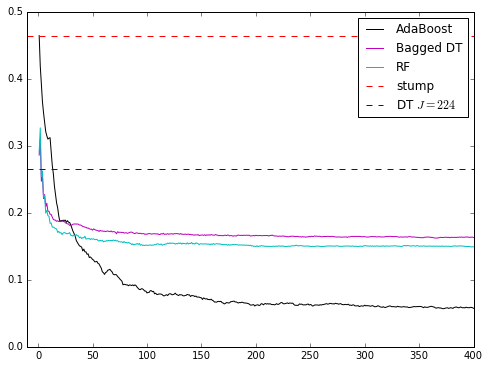

In [36]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_ylim(0, 0.50) ; ax.set_xlim(-10, ada_.n_estimators)
ax.plot(1+np.arange(ada_.n_estimators), 1-ada_scores_, c="k", label="AdaBoost")
ax.plot(1+np.arange(bag_.n_estimators), 1-bag_scores_, c="m", label="Bagged DT")
ax.plot(1+np.arange(bag_.n_estimators), 1-rdf_scores_, c="c", label="RF")
ax.axhline(y=1 - stump_.score(X_test, y_test), c="r", linestyle="--", label="stump")
ax.axhline(y=1 - t224_.score(X_test, y_test), c="b", linestyle="--", label="DT $J=224$")
ax.legend(loc="best")

An excerpt from **HTF, p. 340**
> Here the weak classifier is just a two terminal-node classification tree.
Applying this classifier alone to the training data set yields a very poor
test set error rate of 46.5%, compared to 50% for random guessing. However,
as boosting iterations proceed the error rate steadily decreases, reaching
5.8% after 400 iterations. Thus, boosting this simple very weak classifier
reduces its prediction error rate by almost a factor of four. It also
outperforms a single large classification tree (error rate 26.7%).


We also see that the Bagged Decision Tree and the Random Forest Classifiers
converge much faster to their asymptotic test error: it takes less than 25
trees for Bagging, and approximately 25 for Random forest.